# 0. Características del entorno

In [2]:
!nvidia-smi

Sun Feb  2 22:10:44 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       On  |   00000000:00:04.0 Off |                    0 |
| N/A   50C    P8              9W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Descargar dataset de Kaggle

In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("thedatasith/sku110k-annotations")

print("Path to dataset files:", path)

100%|██████████| 13.2G/13.2G [01:50<00:00, 128MB/s] 

Extracting files...


Path to dataset files: /home/jupyter/.cache/kagglehub/datasets/thedatasith/sku110k-annotations/versions/14


In [7]:
# LLevar el dataset a nuestro directorio
!mv /home/jupyter/.cache/kagglehub/datasets/thedatasith/sku110k-annotations/versions/14 .

# 2. Mostrar imagens
- En caso de que no este en formato Yolo, se puede convertir a este formato.

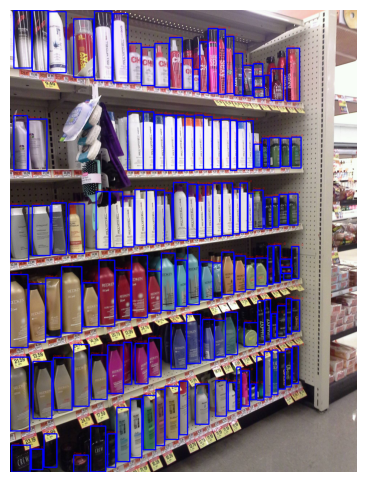

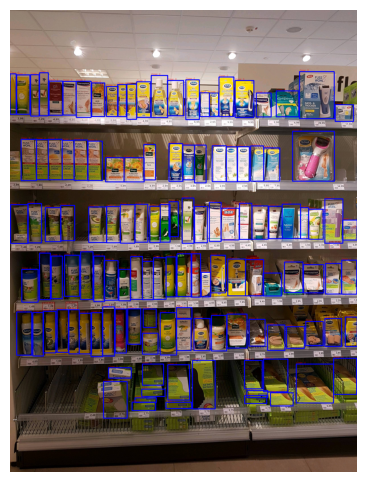

In [4]:
import cv2
import os
import matplotlib.pyplot as plt

def mostrar_imagen_con_bounding_boxes(image_path, label_path):
    # Cargar la imagen
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB para mostrar con Matplotlib
    
    # Obtener el tamaño de la imagen
    height, width, _ = image.shape

    # Leer el archivo de etiquetas
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Dibujar cada bounding box
    for line in lines:
        label_info = line.strip().split()
        class_id = int(label_info[0])  # Clase (0 = producto general)
        x_centro, y_centro, ancho, alto = map(float, label_info[1:])

        # Convertir de formato YOLO a coordenadas (x_min, y_min, x_max, y_max)
        x_min = int((x_centro - ancho / 2) * width)
        y_min = int((y_centro - alto / 2) * height)
        x_max = int((x_centro + ancho / 2) * width)
        y_max = int((y_centro + alto / 2) * height)

        # Dibujar la bounding box en la imagen
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 0, 255), 5)  # Azul para la caja
        cv2.putText(image, f'Clase: {class_id}', (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Mostrar la imagen con Matplotlib
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    return image

# Ruta a las imágenes y labels
image_path = '/home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/images/train'
label_path = '/home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/labels/train'

#image_file = 'SKU110K_fixed/images/train/train_0.jpg'
#label_file = 'SKU110K_fixed/labels/train/train_0.txt'

# Mostrar la imagen con bounding boxes
for file in os.listdir(image_path)[10:12]:
    image_file = os.path.join(image_path, file)
    label_file = os.path.join(label_path, file)
    label_file = label_file.replace('.jpg','.txt')
    #print(file, image_file, label_file)
    mostrar_imagen_con_bounding_boxes(image_file, label_file)


SKU110K_fixed/images/train/train_5626.jpg


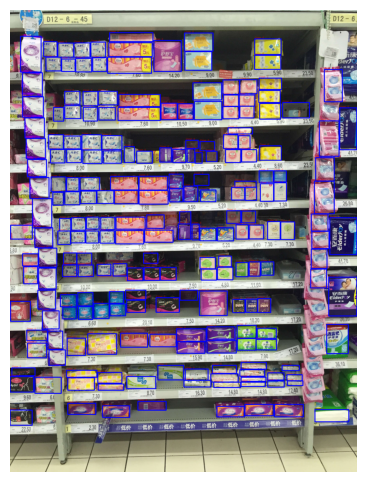

In [5]:
# Otra Forma de mostrar
import glob

# Mostrar todas las imágenes de entrenamiento con sus bounding boxes
image_files = glob.glob('SKU110K_fixed/images/train/*.jpg')

for image_file in image_files[110:111]:
    print(image_file)
    label_file = image_file.replace('images', 'labels').replace('.jpg', '.txt')
    if os.path.exists(label_file):
        image = mostrar_imagen_con_bounding_boxes(image_file, label_file)

In [6]:
# Escribir imagen etiquetada
output_image = 'outputs/SKU110K_fixed/train_5626.jpg'
cv2.imwrite(output_image, cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

True

# 3. Entrenar modelo.

## 3.1 Configigurar archivo Yaml

In [8]:
from ultralytics import YOLO

In [9]:
%%writefile sku110k_yolo.yaml
path: /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/images # dataset root dir
train: train  # train images (relative to 'path')  8219 images
val: val  # val images (relative to 'path')  588 images
#test: test  # test images (optional)  2936 images

# Classes
nc: 1  # number of classes
names: ['object']  # class names

Overwriting sku110k_yolo.yaml


## 3.2. Entrenar el modelo

In [10]:
%%time
# Cargar el modelo YOLOv8 preentrenado
model = YOLO('yolov8n.pt')  # Puedes usar yolov8s.pt o yolov8m.pt para más precisión

# Entrenamiento del modelo
model.train(
    data='sku110k_yolo.yaml',  # Archivo YAML del dataset
    epochs=50,  # Número de épocas de entrenamiento
    imgsz=640,  # Tamaño de las imágenes
    batch=4,  # Tamaño del batch
    name='yolo_sku110k',  # Nombre del proyecto
    device='cuda'  # Usar GPU para entrenamiento
)


Ultralytics 8.3.70 🚀 Python-3.10.15 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14918MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=sku110k_yolo.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=yolo_sku110k, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, 

train: Scanning /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/labels/train... 8185 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8185/8185 [00:32<00:00, 251.69it/s]

train: WARNING ⚠️ /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/images/train/train_1797.jpg: 3 duplicate labels removed


train: New cache created: /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/labels/train.cache


val: Scanning /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/labels/val... 584 images, 0 backgrounds, 0 corrupt: 100%|██████████| 584/584 [00:02<00:00, 276.16it/s]

val: New cache created: /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/labels/val.cache


Plotting labels to runs/detect/yolo_sku110k/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/yolo_sku110k
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.81G      1.763      1.145      1.119         93        640: 100%|██████████| 2047/2047 [04:50<00:00,  7.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.34it/s]


                   all        584      90456      0.704      0.688       0.73      0.414

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50       3.3G       1.57     0.8283      1.046        426        640: 100%|██████████| 2047/2047 [04:16<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.96it/s]


                   all        584      90456       0.84       0.76      0.838      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.83G      1.534     0.7892      1.033        243        640: 100%|██████████| 2047/2047 [04:24<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.47it/s]


                   all        584      90456      0.852      0.768      0.846       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.64G      1.508     0.7667      1.023        156        640: 100%|██████████| 2047/2047 [04:11<00:00,  8.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.91it/s]


                   all        584      90456      0.861       0.78      0.858      0.524

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.75G      1.496     0.7528      1.017         82        640: 100%|██████████| 2047/2047 [04:21<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]


                   all        584      90456      0.859      0.775      0.854      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      5.17G      1.485     0.7418      1.014        284        640: 100%|██████████| 2047/2047 [04:16<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.77it/s]

                   all        584      90456      0.863       0.78      0.862      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.17G      1.473     0.7256      1.008        215        640: 100%|██████████| 2047/2047 [04:19<00:00,  7.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.16it/s]


                   all        584      90456      0.874      0.793       0.87      0.536

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.09G      1.462      0.721      1.005        406        640: 100%|██████████| 2047/2047 [04:19<00:00,  7.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.46it/s]


                   all        584      90456       0.88      0.791       0.87      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.14G      1.455      0.714      1.002        164        640: 100%|██████████| 2047/2047 [04:17<00:00,  7.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.09it/s]


                   all        584      90456      0.879      0.795      0.871      0.542

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      3.23G       1.45     0.7084      1.001        433        640: 100%|██████████| 2047/2047 [04:19<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]


                   all        584      90456       0.88      0.801      0.876      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.62G      1.443     0.7005     0.9976        201        640: 100%|██████████| 2047/2047 [04:16<00:00,  7.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.24it/s]


                   all        584      90456      0.878      0.796      0.873      0.545

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.82G      1.436     0.6965     0.9955        403        640: 100%|██████████| 2047/2047 [04:24<00:00,  7.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.22it/s]


                   all        584      90456      0.881      0.802      0.877      0.548

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.16G      1.433     0.6902     0.9933        225        640: 100%|██████████| 2047/2047 [04:16<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]

                   all        584      90456      0.884      0.806      0.878       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.44G       1.43     0.6862     0.9906        449        640: 100%|██████████| 2047/2047 [04:25<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.97it/s]


                   all        584      90456      0.884      0.806       0.88      0.551

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.48G      1.428     0.6835      0.992        287        640: 100%|██████████| 2047/2047 [04:17<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.80it/s]


                   all        584      90456      0.888      0.806      0.881      0.553

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.12G      1.417     0.6777     0.9891        138        640: 100%|██████████| 2047/2047 [04:25<00:00,  7.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.93it/s]


                   all        584      90456      0.889      0.808      0.884      0.556

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.32G      1.416     0.6745     0.9882        255        640: 100%|██████████| 2047/2047 [04:20<00:00,  7.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.44it/s]

                   all        584      90456       0.89      0.811      0.885      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.61G      1.416     0.6739     0.9879        489        640: 100%|██████████| 2047/2047 [04:31<00:00,  7.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.08it/s]


                   all        584      90456      0.889       0.81      0.885      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.21G      1.412     0.6721     0.9864        379        640: 100%|██████████| 2047/2047 [04:23<00:00,  7.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.42it/s]


                   all        584      90456      0.889      0.809      0.885      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50         5G      1.412     0.6696     0.9852        156        640: 100%|██████████| 2047/2047 [04:23<00:00,  7.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.52it/s]


                   all        584      90456      0.892      0.814      0.888      0.562

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.91G      1.407     0.6648     0.9862         49        640: 100%|██████████| 2047/2047 [04:28<00:00,  7.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.52it/s]

                   all        584      90456      0.893      0.815      0.888      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.73G      1.403     0.6632     0.9839        179        640: 100%|██████████| 2047/2047 [04:29<00:00,  7.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:14<00:00,  5.12it/s]


                   all        584      90456      0.894      0.814      0.889      0.563

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.31G      1.398     0.6581     0.9823        154        640: 100%|██████████| 2047/2047 [04:28<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.90it/s]


                   all        584      90456      0.895      0.816      0.891      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.53G      1.395     0.6573     0.9818        132        640: 100%|██████████| 2047/2047 [04:24<00:00,  7.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:14<00:00,  4.94it/s]


                   all        584      90456      0.896      0.817      0.892      0.564

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.39G      1.396     0.6553     0.9791        339        640: 100%|██████████| 2047/2047 [04:37<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:14<00:00,  4.96it/s]

                   all        584      90456      0.893      0.818      0.891      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.84G      1.391     0.6506     0.9785        133        640: 100%|██████████| 2047/2047 [04:39<00:00,  7.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:15<00:00,  4.84it/s]


                   all        584      90456      0.897      0.818      0.893      0.566

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.36G      1.391     0.6504      0.979        297        640: 100%|██████████| 2047/2047 [04:50<00:00,  7.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.27it/s]


                   all        584      90456      0.896       0.82      0.893      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.39G       1.39     0.6498     0.9787        260        640: 100%|██████████| 2047/2047 [04:31<00:00,  7.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.38it/s]


                   all        584      90456      0.898      0.819      0.892      0.567

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      3.55G      1.384     0.6463     0.9767        199        640: 100%|██████████| 2047/2047 [04:43<00:00,  7.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.41it/s]


                   all        584      90456      0.898      0.818      0.893      0.568

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      3.68G      1.389     0.6441     0.9769        211        640: 100%|██████████| 2047/2047 [04:32<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.01it/s]

                   all        584      90456      0.898      0.819      0.893      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      5.35G      1.382     0.6417     0.9767        214        640: 100%|██████████| 2047/2047 [04:43<00:00,  7.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:14<00:00,  5.06it/s]


                   all        584      90456        0.9      0.822      0.895       0.57

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50       3.5G      1.377     0.6388     0.9751        208        640: 100%|██████████| 2047/2047 [04:38<00:00,  7.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.72it/s]


                   all        584      90456      0.899      0.821      0.896      0.571

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.07G      1.377      0.638      0.974        235        640: 100%|██████████| 2047/2047 [04:37<00:00,  7.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.44it/s]


                   all        584      90456      0.902      0.822      0.897      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.29G      1.382       0.64      0.975        387        640: 100%|██████████| 2047/2047 [04:16<00:00,  7.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.59it/s]


                   all        584      90456        0.9      0.824      0.898      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      3.32G      1.376     0.6358     0.9736        413        640: 100%|██████████| 2047/2047 [04:30<00:00,  7.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.52it/s]


                   all        584      90456      0.902      0.823      0.898      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.77G      1.373     0.6346     0.9736        123        640: 100%|██████████| 2047/2047 [04:19<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.19it/s]


                   all        584      90456      0.902      0.824      0.899      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.84G      1.373     0.6328     0.9719        381        640: 100%|██████████| 2047/2047 [04:29<00:00,  7.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:14<00:00,  5.13it/s]


                   all        584      90456      0.903      0.823      0.898      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.16G      1.371     0.6316     0.9725        381        640: 100%|██████████| 2047/2047 [04:30<00:00,  7.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.31it/s]


                   all        584      90456      0.901      0.825      0.898      0.573

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      3.75G      1.365     0.6261     0.9707         94        640: 100%|██████████| 2047/2047 [04:34<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  5.94it/s]


                   all        584      90456      0.902      0.826      0.901      0.574
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.34G      1.361     0.6231     0.9856        200        640: 100%|██████████| 2047/2047 [04:04<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:14<00:00,  5.15it/s]


                   all        584      90456      0.901      0.825      0.898      0.572

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50         2G      1.356     0.6166     0.9813        113        640: 100%|██████████| 2047/2047 [04:02<00:00,  8.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.06it/s]

                   all        584      90456      0.901      0.826      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.38G       1.35      0.614     0.9807        167        640: 100%|██████████| 2047/2047 [03:53<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.09it/s]


                   all        584      90456      0.904      0.825      0.899      0.574

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.37G       1.35     0.6116     0.9819        122        640: 100%|██████████| 2047/2047 [04:07<00:00,  8.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.01it/s]


                   all        584      90456      0.905      0.825        0.9      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.43G      1.347     0.6101     0.9808        119        640: 100%|██████████| 2047/2047 [03:53<00:00,  8.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.16it/s]

                   all        584      90456      0.907      0.825        0.9      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.36G      1.344     0.6073     0.9791        115        640: 100%|██████████| 2047/2047 [04:04<00:00,  8.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:13<00:00,  5.58it/s]


                   all        584      90456      0.904      0.827        0.9      0.575

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50       2.1G      1.345     0.6066     0.9801        206        640: 100%|██████████| 2047/2047 [03:58<00:00,  8.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.13it/s]

                   all        584      90456      0.905      0.827      0.901      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.81G       1.34     0.6032     0.9777        120        640: 100%|██████████| 2047/2047 [03:59<00:00,  8.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.21it/s]


                   all        584      90456      0.905      0.827      0.901      0.576

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      3.05G      1.341     0.6026     0.9776        107        640: 100%|██████████| 2047/2047 [04:03<00:00,  8.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:11<00:00,  6.41it/s]

                   all        584      90456      0.906      0.827      0.901      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.13G      1.339     0.6007     0.9772        106        640: 100%|██████████| 2047/2047 [03:53<00:00,  8.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:12<00:00,  6.03it/s]


                   all        584      90456      0.908      0.826      0.901      0.576

50 epochs completed in 3.826 hours.
Optimizer stripped from runs/detect/yolo_sku110k/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolo_sku110k/weights/best.pt, 6.2MB

Validating runs/detect/yolo_sku110k/weights/best.pt...
Ultralytics 8.3.70 🚀 Python-3.10.15 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14918MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 73/73 [00:30<00:00,  2.40it/s]


                   all        584      90456      0.908      0.826      0.901      0.576
Speed: 0.2ms preprocess, 2.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/yolo_sku110k
CPU times: user 3h 31min 1s, sys: 6min 3s, total: 3h 37min 4s
Wall time: 3h 51min 3s


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff4d8bf6f20>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [12]:
# Evaluación del modelo
metrics = model.val()
print(metrics)

Ultralytics 8.3.70 🚀 Python-3.10.15 torch-1.13.1+cu117 CUDA:0 (Tesla T4, 14918MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /home/jupyter/ejecucionPDV/identificarSKUs/SKU110K_fixed/labels/val.cache... 584 images, 0 backgrounds, 0 corrupt: 100%|██████████| 584/584 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 146/146 [00:25<00:00,  5.65it/s]


                   all        584      90456      0.908      0.826      0.901      0.577
Speed: 0.3ms preprocess, 5.6ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to runs/detect/yolo_sku110k2
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff4d8c90910>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,  

#### Resultados de las métricas del entrenamiento
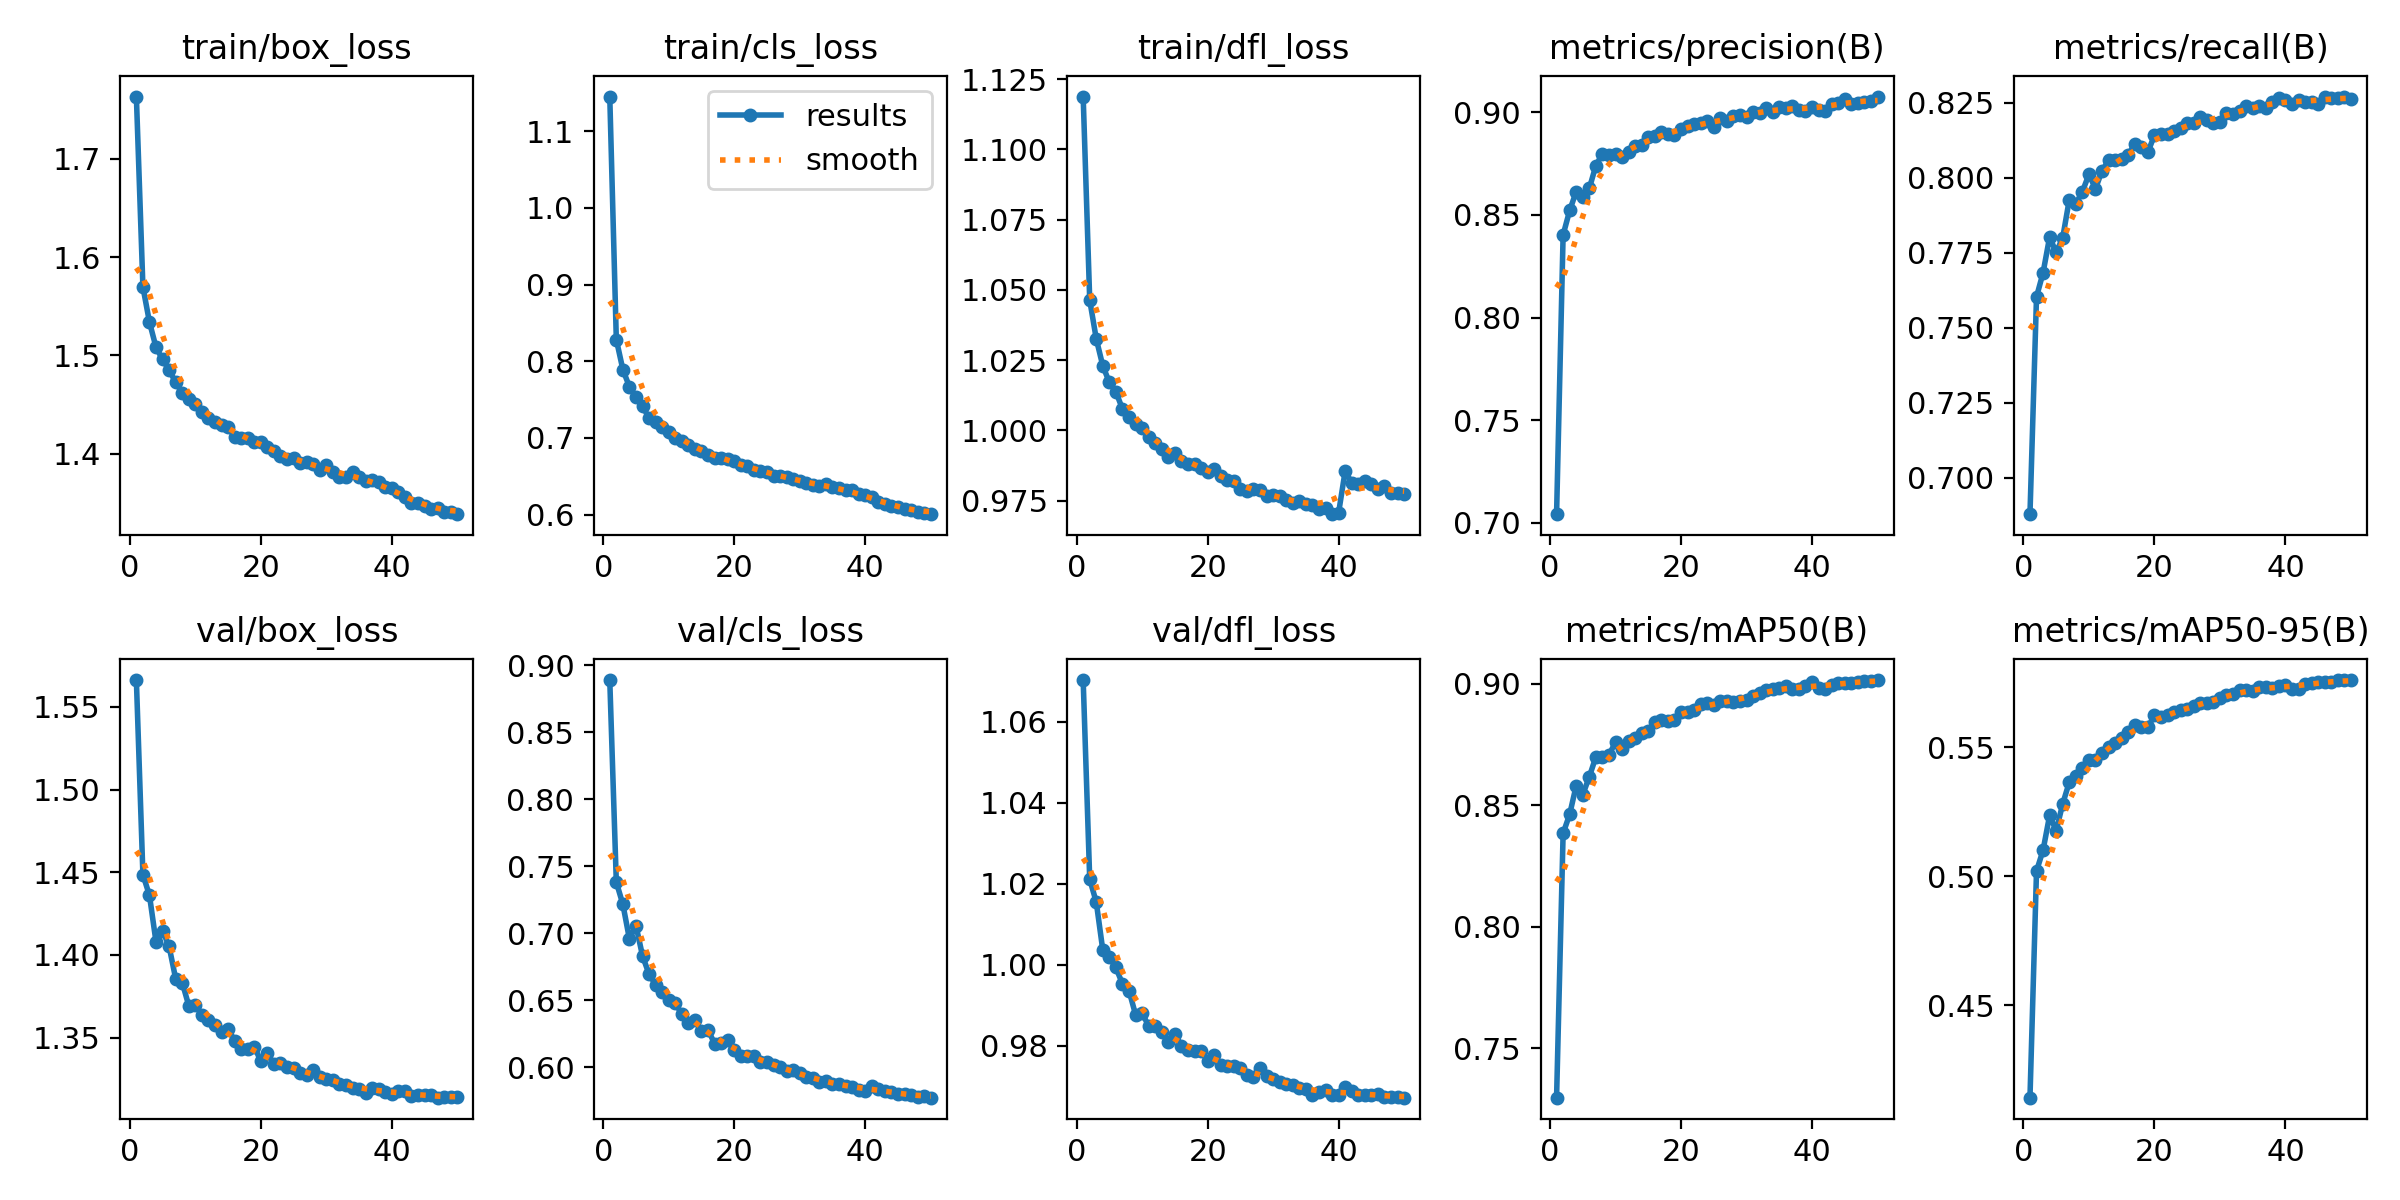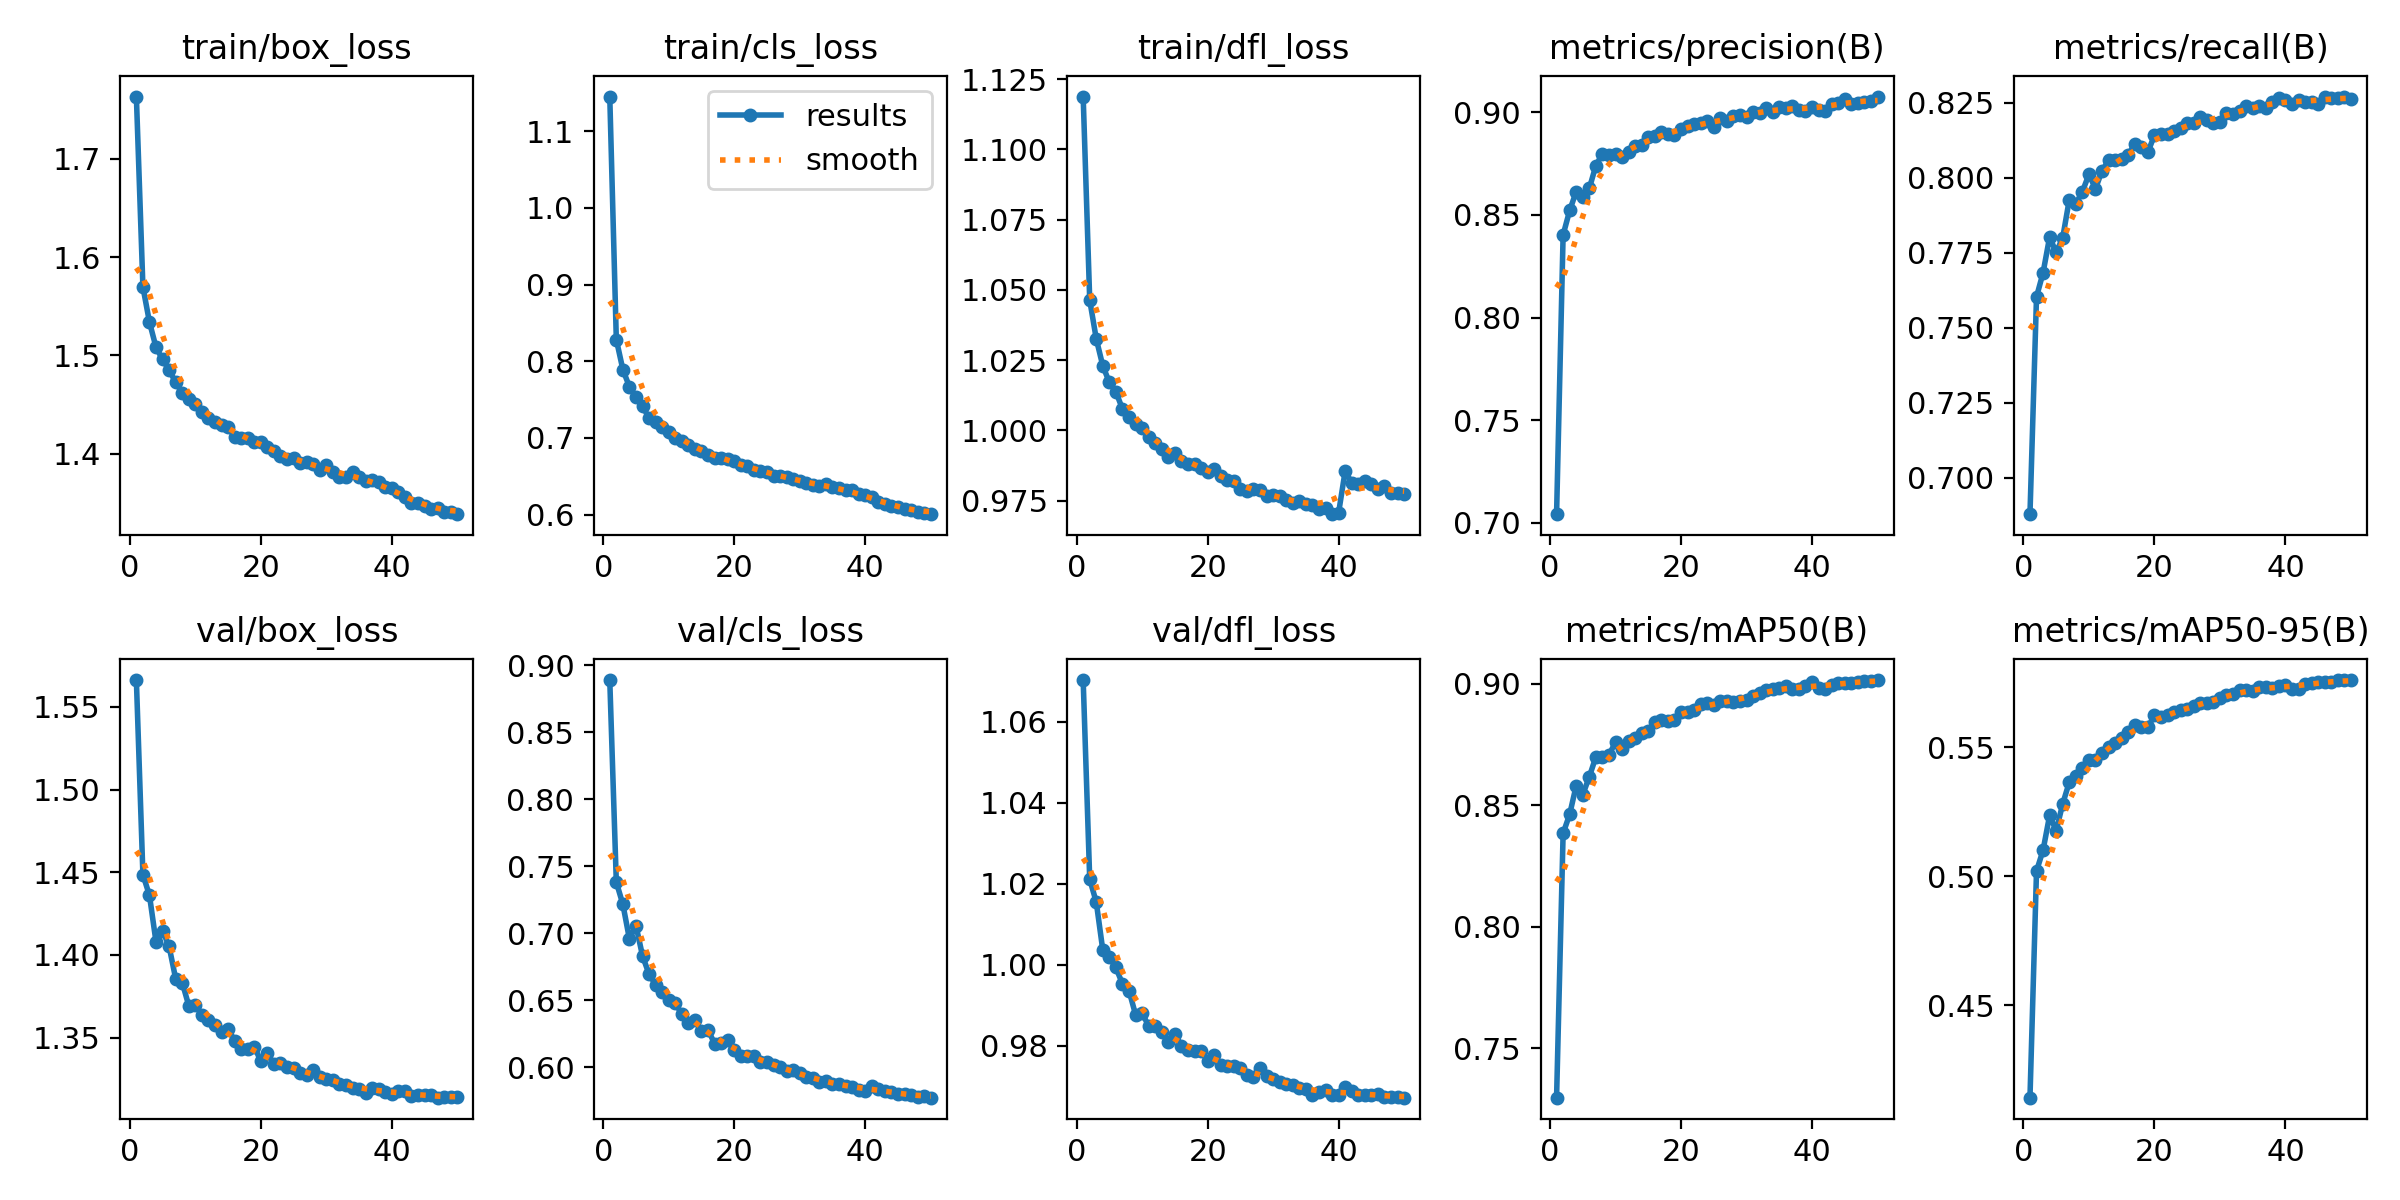

# 4. Pasar el modelo entrenado a nuevas imagenes - Gondolas

In [4]:
# Cargar el modelo entrenado de ser necesario
from ultralytics import YOLO
import os

In [5]:
# Cargar el modelo guardado
path_model = 'runs/detect/yolo_sku110k/weights/best.pt'
path_new_images = 'inputs/estantes/images'
path_new_labels = 'inputs/estantes/labels'
# Directorio donde se guardarán las predicciones
output_dir = path_new_labels#"outputs/gondolas"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# Cargar el modelo
train_model = YOLO(path_model)

# Realizar predicciones en imágenes nuevas
for image in os.listdir(path_new_images):
    if image.endswith('.ipynb_checkpoints'):
        pass
    else:
        # Construir el path
        path_new_image = os.path.join(path_new_images, image)
        print(path_new_image)
        results = train_model.predict(source=path_new_image, save=True)

        # Guardar bounding boxes en formato YOLO
        for result in results:
            img_path = result.path
            boxes = result.boxes.xywhn  # Bounding boxes normalizadas
            confidences = result.boxes.conf  # Confianza

            # Crear archivo de salida .txt
            image_name = os.path.basename(img_path).replace(".jpg", ".txt")
            output_file = os.path.join(output_dir, image_name)

            with open(output_file, "w") as f:
                for box, conf in zip(boxes, confidences):
                    x, y, w, h = box  # Coordenadas normalizadas
                    class_id = 0  # Clase: productos generales
                    f.write(f"{class_id} {x} {y} {w} {h} {conf}\n")


inputs/estantes/images/estante4.jpg

image 1/1 /home/jupyter/ejecucionPDV/identificarSKUs/inputs/estantes/images/estante4.jpg: 480x640 53 objects, 18.4ms
Speed: 4.1ms preprocess, 18.4ms inference, 3.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2
inputs/estantes/images/estante5.jpg

image 1/1 /home/jupyter/ejecucionPDV/identificarSKUs/inputs/estantes/images/estante5.jpg: 480x640 182 objects, 10.6ms
Speed: 2.1ms preprocess, 10.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict2
inputs/estantes/images/estante1.jpg

image 1/1 /home/jupyter/ejecucionPDV/identificarSKUs/inputs/estantes/images/estante1.jpg: 640x320 38 objects, 18.3ms
Speed: 1.6ms preprocess, 18.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)
Results saved to runs/detect/predict2
inputs/estantes/images/estante2.jpg

image 1/1 /home/jupyter/ejecucionPDV/identificarSKUs/inputs/estantes/images/estante2.jpg: 640x4

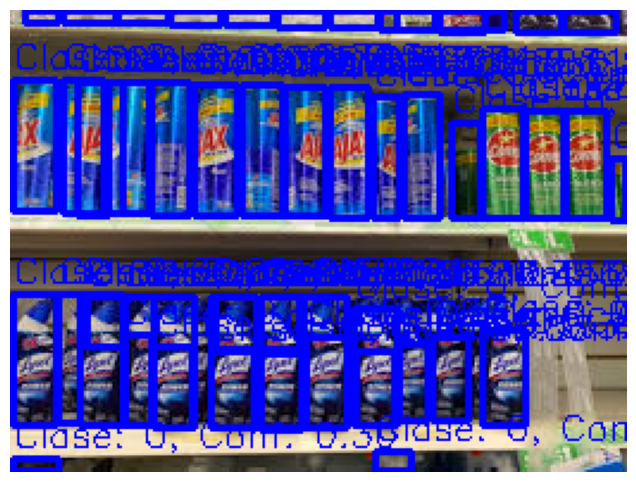

Guardada/reemplazada la imagen con bounding boxes: outputs/predicted_estantes/estante4.jpg


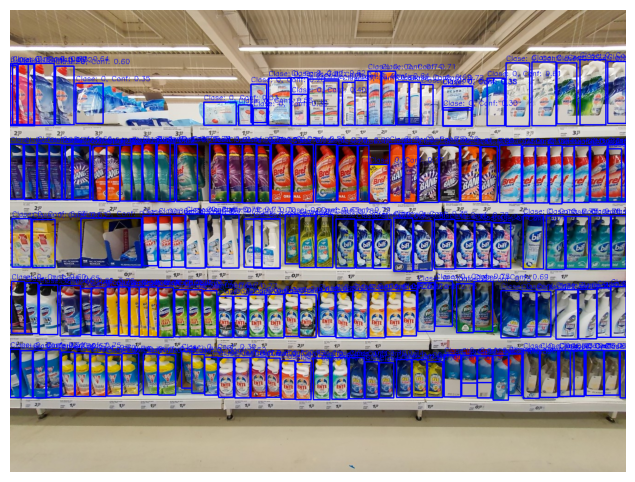

Guardada/reemplazada la imagen con bounding boxes: outputs/predicted_estantes/estante5.jpg


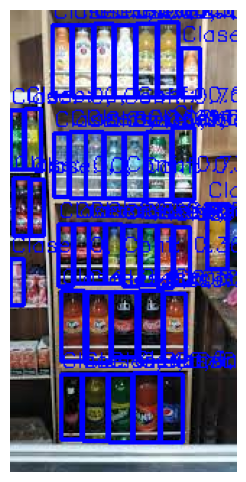

Guardada/reemplazada la imagen con bounding boxes: outputs/predicted_estantes/estante1.jpg


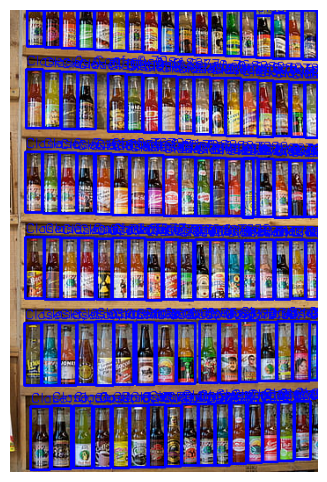

Guardada/reemplazada la imagen con bounding boxes: outputs/predicted_estantes/estante2.jpg


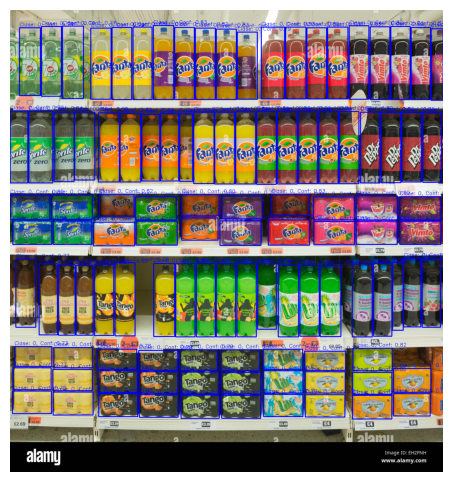

Guardada/reemplazada la imagen con bounding boxes: outputs/predicted_estantes/estante3.jpg


In [7]:
# Mostrar imágenes etiquetadas y guardarlas
import os
import cv2
import matplotlib.pyplot as plt

# Paths de las imágenes y etiquetas
path_new_images = 'inputs/estantes/images'
path_new_labels = 'inputs/estantes/labels'
path_predict_new = 'outputs/predicted_estantes'

# Crear el directorio de salida si no existe
if not os.path.exists(path_predict_new):
    os.makedirs(path_predict_new)

def mostrar_y_guardar_bounding_boxes(image_path, label_path, output_path):
    # Cargar la imagen
    image = cv2.imread(image_path)
    
    # Obtener el tamaño de la imagen
    height, width, _ = image.shape

    # Leer el archivo de etiquetas
    with open(label_path, 'r') as f:
        lines = f.readlines()

    # Dibujar cada bounding box
    for line in lines:
        label_info = line.strip().split()
        class_id = int(label_info[0])  # Clase (0 = productos generales)
        x_centro, y_centro, ancho, alto, conf = map(float, label_info[1:])

        # Convertir de formato YOLO a coordenadas (x_min, y_min, x_max, y_max)
        x_min = int((x_centro - ancho / 2) * width)
        y_min = int((y_centro - alto / 2) * height)
        x_max = int((x_centro + ancho / 2) * width)
        y_max = int((y_centro + alto / 2) * height)

        # Dibujar la bounding box en la imagen
        color = (255, 0, 0)  # Azul para las cajas
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, 2)
        cv2.putText(image, f'Clase: {class_id}, Conf: {conf:.2f}', (x_min, y_min - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Mostrar la imagen en el notebook
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    # Guardar la imagen con bounding boxes en el directorio de salida (reemplazando si ya existe)
    output_image_path = os.path.join(output_path, os.path.basename(image_path))
    cv2.imwrite(output_image_path, image)
    print(f"Guardada/reemplazada la imagen con bounding boxes: {output_image_path}")

# Iterar sobre las imágenes y sus correspondientes archivos de etiquetas
for image_file in os.listdir(path_new_images):
    if image_file.endswith('.jpg') or image_file.endswith('.png'):
        image_path = os.path.join(path_new_images, image_file)
        label_path = os.path.join(path_new_labels, image_file.replace('.jpg', '.txt').replace('.png', '.txt'))

        if os.path.exists(label_path):  # Verificar que exista el archivo de etiquetas
            mostrar_y_guardar_bounding_boxes(image_path, label_path, path_predict_new)
